In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import itertools
import numpy as np
import math
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [2]:
## References: http://dacatay.com/data-science/part-4-time-series-prediction-arima-python/

In [3]:
demand = pd.read_csv('../data/external/Historical Product Demand.csv', low_memory=False)
list(demand)

['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand']

In [4]:
demand.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,7/27/12,100
1,Product_0979,Whse_J,Category_028,1/19/12,500
2,Product_0979,Whse_J,Category_028,2/3/12,500
3,Product_0979,Whse_J,Category_028,2/9/12,500
4,Product_0979,Whse_J,Category_028,3/2/12,500


In [5]:
demand.Product_Code.unique()

array(['Product_0993', 'Product_0979', 'Product_1159', ...,
       'Product_0237', 'Product_0644', 'Product_0853'], dtype=object)

In [6]:
## Which product has maximum demand?

In [7]:
demand.groupby("Product_Code").sum().sort_values("Order_Demand", ascending=False).head(1)

,Order_Demand
Product_Code,
Product_1359,470710000


In [8]:
## Which warehouse has maximum demand?

In [9]:
demand.groupby("Warehouse").sum().sort_values("Order_Demand", ascending=False).head(1)

,Order_Demand
Warehouse,
Whse_J,3344521718


In [10]:
## Which product category has maximum demand?

In [11]:
demand.groupby("Product_Category").sum().sort_values("Order_Demand", ascending=False).head(1)

,Order_Demand
Product_Category,
Category_019,4219816665


In [12]:
##Picking the product with most order demand

In [13]:
product = demand.loc[demand['Product_Code'] == 'Product_1359']

In [14]:
product['Date'].min(), product['Date'].max()

('1/10/12', '9/9/16')

In [15]:
product.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
276,Product_1359,Whse_J,Category_019,4/18/12,80000
282,Product_1359,Whse_J,Category_019,5/21/12,70000
289,Product_1359,Whse_J,Category_019,6/26/12,80000
292,Product_1359,Whse_J,Category_019,7/17/12,100000
296,Product_1359,Whse_J,Category_019,8/24/12,100000


In [16]:
product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16936 entries, 276 to 1046518
Data columns (total 5 columns):
Product_Code        16936 non-null object
Warehouse           16936 non-null object
Product_Category    16936 non-null object
Date                16936 non-null object
Order_Demand        16936 non-null int64
dtypes: int64(1), object(4)
memory usage: 793.9+ KB


In [17]:
product = product.drop(columns=['Warehouse','Product_Category','Product_Code'])
product.head()

,Date,Order_Demand
276,4/18/12,80000
282,5/21/12,70000
289,6/26/12,80000
292,7/17/12,100000
296,8/24/12,100000


In [18]:
productnew = product.copy()

In [19]:
productnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16936 entries, 276 to 1046518
Data columns (total 2 columns):
Date            16936 non-null object
Order_Demand    16936 non-null int64
dtypes: int64(1), object(1)
memory usage: 396.9+ KB


In [20]:
productnew.head()

,Date,Order_Demand
276,4/18/12,80000
282,5/21/12,70000
289,6/26/12,80000
292,7/17/12,100000
296,8/24/12,100000


In [21]:
productnew['Date'] = pd.to_datetime(productnew['Date'])

In [22]:
productnew = productnew.set_index('Date')

In [23]:
productnew = productnew.apply(pd.to_numeric, errors='ignore')

In [24]:
productnew.loc[productnew['Order_Demand'].idxmax()]

,Order_Demand
Date,
2016-10-11,10000
2016-10-11,75000
2016-10-11,5000
2016-10-11,10000
2016-10-11,2000000
2016-10-11,23000
2016-10-11,5000
2016-10-11,9000
2016-10-11,10000


In [25]:
productnew = productnew.infer_objects()
productnew.dtypes

Order_Demand    int64
dtype: object

In [26]:
productnew.Order_Demand = productnew.Order_Demand.astype(float)
productnew.dtypes

Order_Demand    float64
dtype: object

In [27]:
productnew.index

DatetimeIndex(['2012-04-18', '2012-05-21', '2012-06-26', '2012-07-17',
               '2012-08-24', '2012-10-04', '2012-10-29', '2012-01-12',
               '2012-01-20', '2012-02-03',
               ...
               '2016-03-18', '2016-04-01', '2016-05-09', '2016-06-02',
               '2016-08-01', '2016-10-03', '2016-09-16', '2016-11-01',
               '2016-12-01', '2016-12-09'],
              dtype='datetime64[ns]', name='Date', length=16936, freq=None)

In [28]:
y = productnew['Order_Demand'].resample('MS').mean()

In [29]:
y.head()

Date
2012-01-01    28554.487179
2012-02-01    22566.197183
2012-03-01    23902.821317
2012-04-01    26467.065868
2012-05-01    26238.390093
Freq: MS, Name: Order_Demand, dtype: float64

In [30]:
y_train = y[:'2016']
y_test = y['2017':]

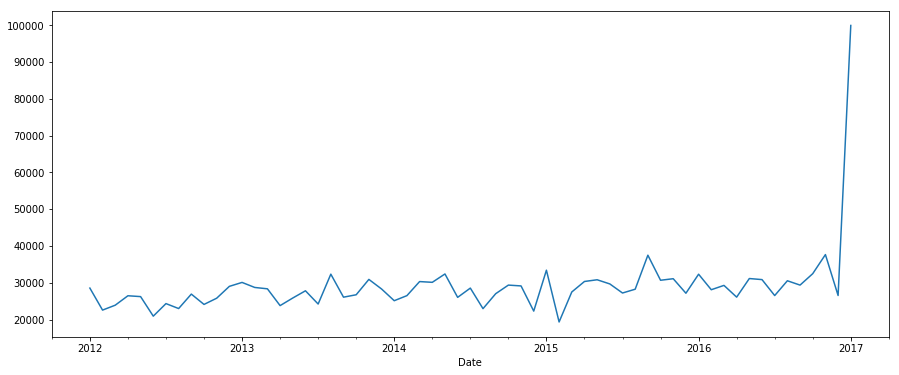

In [31]:
y.plot(figsize=(15, 6))
plt.show()

In [32]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [33]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))


Best SARIMAX(2, 2, 1)x(1, 2, 0, 12)12 model - AIC:720.3779989464242


In [34]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2146      0.339     -0.632      0.527      -0.880       0.451
ma.L1         -0.6901      0.253     -2.723      0.006      -1.187      -0.193
ar.S.L12      -0.5295      0.267     -1.985      0.047      -1.052      -0.007
sigma2      2.773e+07   4.52e-09   6.14e+15      0.000    2.77e+07    2.77e+07


In [35]:
# print statistics
print(res.aic)
print(res.summary())

929.2193552062328
                                 Statespace Model Results                                 
Dep. Variable:                       Order_Demand   No. Observations:                   60
Model:             SARIMAX(2, 2, 1)x(2, 1, 0, 12)   Log Likelihood                -458.610
Date:                            Mon, 22 Oct 2018   AIC                            929.219
Time:                                    19:08:35   BIC                            940.191
Sample:                                01-01-2012   HQIC                           933.329
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4111      0.464     -0.885      0.376      -1.321       0.499
ar.L2         -0.

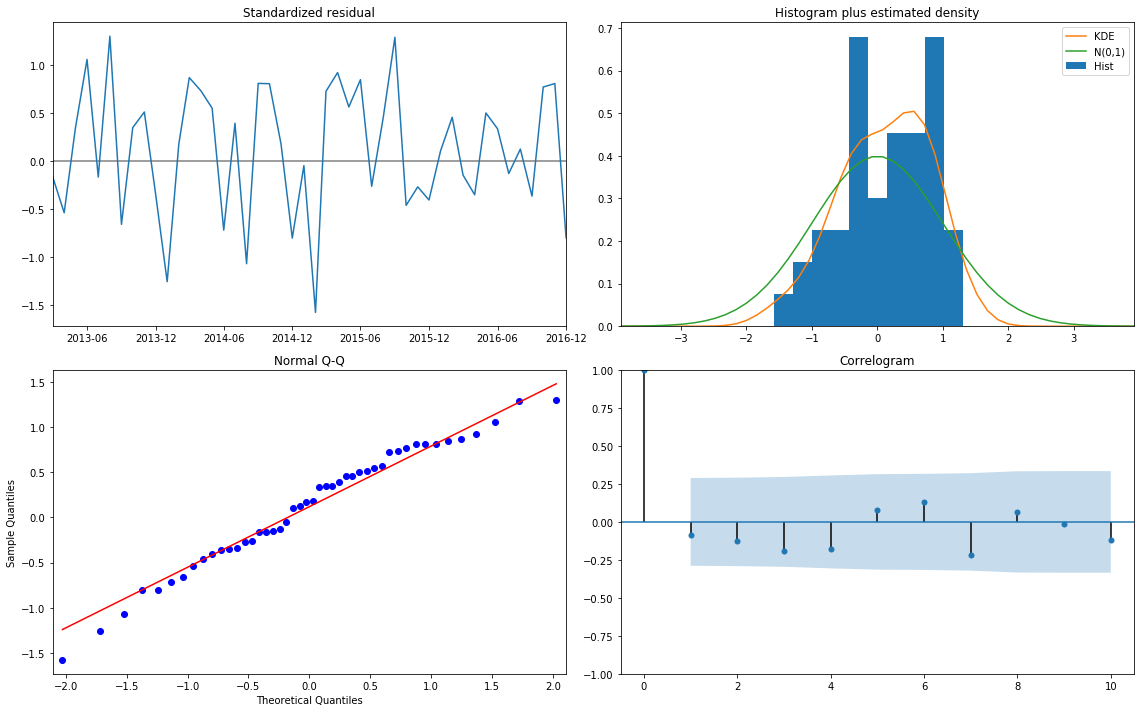

In [36]:
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

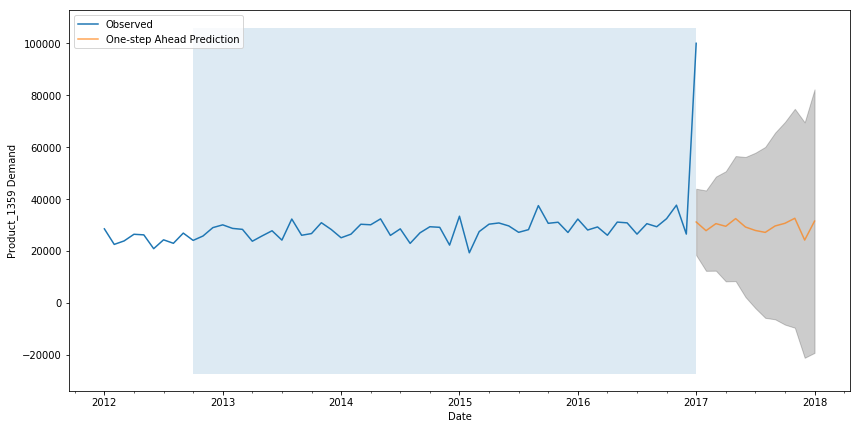

In [37]:
# in-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('2017-01-01'),end=pd.to_datetime('2018-01-01'),
                          dynamic=True)
pred_ci = pred.conf_int()
 
# plot in-sample-prediction
ax = y['2012':].plot(label='Observed');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, figsize=(14, 7));
 
# draw confidence bound 
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='k', alpha=.2);
 
# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-10-01'), y.index[-1], alpha=.15, zorder=-1);
ax.set_xlabel('Date')
ax.set_ylabel('Product_1359 Demand')
plt.legend(loc='upper left')
plt.show()

In [38]:
y_hat = pred.predicted_mean
y_true = y['2012-10-01':]
 
# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 4732965882.12 MSE (68796.55 RMSE)


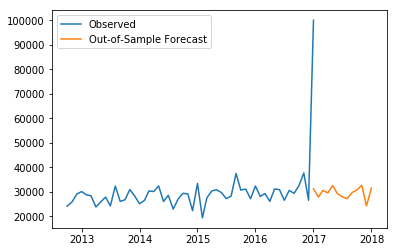

In [39]:
plt.plot(y_true, label='Observed')
plt.plot(y_hat, label='Out-of-Sample Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Product_1359 Demand')
plt.legend(loc='upper left');
plt.show()

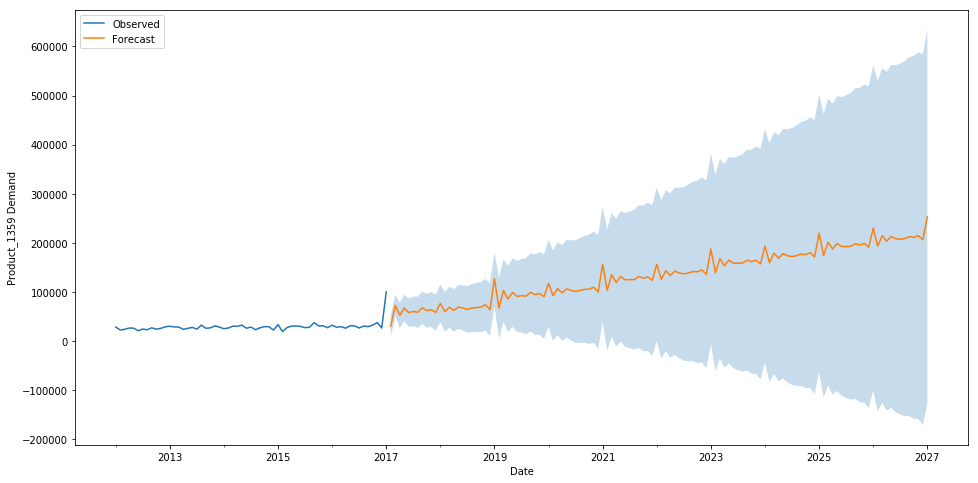

In [40]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
res = mod.fit()
 
# get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=120)
 
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y.plot(label='Observed', figsize=(16, 8));
pred_uc.predicted_mean.plot(ax=ax, label='Forecast');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Product_1359 Demand');
plt.legend(loc='upper left')
plt.show()